Get keywords from title in content

Keywords might be required for building the WordCloud

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksrs9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define a function to convert sentences to words using gensim's simple_preprocess
def sentences_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

def sentence_to_words(sentence):
    return(simple_preprocess(str(sentence), deacc=True))

# Define a function to remove stopwords using gensim's simple_preprocess
def remove_stopwords(docs):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords_en] for doc in docs]

# Define a function to lemmatize given texts
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data = cnt.text_description.values.tolist()
data_words = list(sentences_to_words(data))

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatize(data_words_nostops)

In [ ]:
data_lemmatized_flat = [item for sublist in data_lemmatized for item in sublist]

Build a WordCloud

In [ ]:
from wordcloud import WordCloud

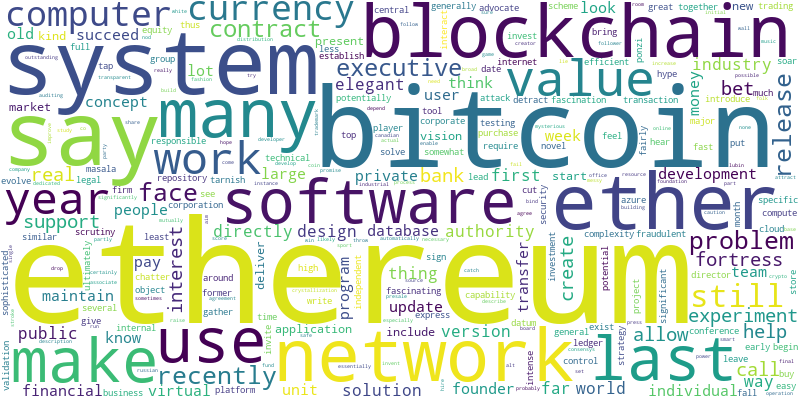

In [ ]:
# Create a wordcloud of trimmed.text_no_punc_lower
long_string = ','.join(data_lemmatized[0])
wc = WordCloud(
    max_words=5000, 
    width=800, 
    height=400,
    background_color="white", 
    contour_width=5, 
    contour_color='steelblue'
)
wc.generate(long_string)
wc.to_image()

Build a Dictionary

In [ ]:
from gensim.corpora import Dictionary

data_dictionary = Dictionary(data_lemmatized)
corpus = [data_dictionary.doc2bow(word_arr) for word_arr in data_lemmatized]

Build an LDA Model

In [ ]:
len(data_lemmatized)

2191

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, 
    id2word=data_dictionary, 
    random_state=42, 
    alpha='auto', 
    eta='auto',
    num_topics=10, 
    # update_every=5, 
    chunksize=20, 
    # passes=10, 
    per_word_topics=True
)

In [ ]:
# Compute Perplexity
lda_model.log_perplexity(corpus)

-8.406452427650224

In [ ]:
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=data_dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.4434263513261981

In [ ]:
lda_model.print_topics()

[(0,
  '0.026*"use" + 0.020*"datum" + 0.010*"build" + 0.009*"application" + 0.008*"example" + 0.008*"project" + 0.008*"need" + 0.007*"test" + 0.007*"also" + 0.007*"image"'),
 (1,
  '0.036*"user" + 0.025*"app" + 0.023*"content" + 0.020*"use" + 0.020*"page" + 0.017*"api" + 0.016*"drupal" + 0.015*"new" + 0.014*"site" + 0.014*"message"'),
 (2,
  '0.011*"make" + 0.010*"time" + 0.010*"work" + 0.009*"get" + 0.008*"way" + 0.007*"well" + 0.007*"people" + 0.007*"go" + 0.007*"take" + 0.007*"say"'),
 (3,
  '0.053*"polymer" + 0.042*"sensor" + 0.029*"motivation" + 0.021*"water" + 0.017*"robotic" + 0.016*"agent" + 0.015*"disease" + 0.014*"cell" + 0.014*"harness" + 0.010*"computation"'),
 (4,
  '0.027*"customer" + 0.020*"company" + 0.013*"new" + 0.013*"business" + 0.013*"technology" + 0.012*"product" + 0.010*"digital" + 0.009*"year" + 0.009*"service" + 0.009*"platform"'),
 (5,
  '0.033*"sql" + 0.033*"query" + 0.029*"queue" + 0.029*"load" + 0.029*"import" + 0.029*"protocol" + 0.025*"mongodb" + 0.018*"c

In [ ]:
num_topics = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['num_topics', 'coherence'])

# Loop through the number of topics
for num in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus, 
        id2word=data_dictionary, 
        random_state=42, 
        alpha='auto', 
        eta='auto',
        num_topics=num, 
        # update_every=5, 
        # chunksize=20, 
        # passes=10, 
        per_word_topics=True
    )
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=data_dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

    # Store the results in the DataFrame and concatenate with the previous results
    results = pd.concat([results, pd.DataFrame({'num_topics': [num], 'coherence': [coherence]})], ignore_index=True)

In [ ]:
results.head()

,num_topics,coherence
0,1,0.277873
1,2,0.272423
2,5,0.277328
3,10,0.289771
4,15,0.301120


In [ ]:
results.sort_values(by='coherence', ascending=True, inplace=True)

In [ ]:
results.head()

,num_topics,coherence
1,2,0.272423
2,5,0.277328
0,1,0.277873
3,10,0.289771
5,20,0.297762


In [ ]:
doc_lda = lda_model[corpus]

In [ ]:
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.01)
all_topics_matrix = gensim.matutils.corpus2csc(all_topics)

In [ ]:
all_topics_arr = all_topics_matrix.T.toarray()
all_topics_df = pd.DataFrame(all_topics_arr)

In [ ]:
all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.328297,0.020649,0.049783,0.0,0.480158,0.019172,0.021079,0.065510,0.0,0.015257
1,0.263440,0.102188,0.000000,0.0,0.306934,0.042200,0.170583,0.089120,0.0,0.018261
2,0.401719,0.098337,0.037390,0.0,0.048835,0.066721,0.000000,0.342952,0.0,0.000000
3,0.391572,0.034330,0.027667,0.0,0.404734,0.000000,0.103398,0.029493,0.0,0.000000
4,0.178129,0.015916,0.139978,0.0,0.330505,0.000000,0.000000,0.294955,0.0,0.036373


In [ ]:
def get_topic_indices(row):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_indices = [x[0] for x in row]
    return topic_indices

In [ ]:
# Map the get_topic_indices function to lda_model[corpus]
topic_indices = list(map(get_topic_indices, lda_model[corpus]))

In [ ]:
topic_indices[0]

[4, 0, 7, 2, 6, 1, 5, 9]

In [ ]:
# Convert topic_indices to a Series, and convert the Series into a DataFrame
topic_indices_df = pd.DataFrame(pd.Series(topic_indices))

In [ ]:
topic_indices_df.head()

,0
0,"[4, 0, 7, 2, 6, 1, 5, 9]"
1,"[4, 0, 6, 1, 7, 5, 9]"
2,"[0, 7, 1, 5, 4, 2]"
3,"[4, 0, 6, 1, 7, 2]"
4,"[4, 7, 0, 2, 9, 1]"


In [ ]:
cnt.head()

,index,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,item_type,item_url,title,text_description,language,item_id_adj,topic_indices
0,1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1190,"[4, 0, 6, 7, 5, 1]"
1,2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,811,"[6, 4, 0, 7, 5, 1, 9]"
2,3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,559,"[0, 7, 1, 5, 4]"
3,4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,2988,"[4, 0, 6, 9, 7]"
4,5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,1191,"[4, 7, 0, 5, 2, 1]"


In [ ]:
# Concatenate cnt and topic_indices_df
cnt = pd.concat([cnt, topic_indices_df], axis=1)

In [ ]:
cnt.head()

,index,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,item_type,item_url,title,text_description,language,item_id_adj,topic_indices,0
0,1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1190,"[4, 0, 6, 7, 5, 1]","[4, 0, 7, 2, 6, 1, 5, 9]"
1,2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,811,"[6, 4, 0, 7, 5, 1, 9]","[4, 0, 6, 1, 7, 5, 9]"
2,3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,559,"[0, 7, 1, 5, 4]","[0, 7, 1, 5, 4, 2]"
3,4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,2988,"[4, 0, 6, 9, 7]","[4, 0, 6, 1, 7, 2]"
4,5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,1191,"[4, 7, 0, 5, 2, 1]","[4, 7, 0, 2, 9, 1]"


In [ ]:
# Rename column 0 to topic_indices
cnt.rename(columns={0: 'topic_indices'}, inplace=True)

In [ ]:
cnt.head()

,index,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,item_type,item_url,title,text_description,language,item_id_adj,topic_indices,topic_indices
0,1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1190,"[4, 0, 6, 7, 5, 1]","[4, 0, 7, 2, 6, 1, 5, 9]"
1,2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,811,"[6, 4, 0, 7, 5, 1, 9]","[4, 0, 6, 1, 7, 5, 9]"
2,3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,559,"[0, 7, 1, 5, 4]","[0, 7, 1, 5, 4, 2]"
3,4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,2988,"[4, 0, 6, 9, 7]","[4, 0, 6, 1, 7, 2]"
4,5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,1191,"[4, 7, 0, 5, 2, 1]","[4, 7, 0, 2, 9, 1]"


[(0,
  '0.013*"work" + 0.011*"make" + 0.011*"time" + 0.010*"team" + 0.009*"people" + 0.008*"way" + 0.007*"get" + 0.007*"well" + 0.007*"take" + 0.007*"good"'),
 (1,
  '0.026*"use" + 0.015*"code" + 0.008*"page" + 0.008*"file" + 0.007*"test" + 0.007*"create" + 0.006*"content" + 0.006*"feature" + 0.006*"make" + 0.006*"time"'),
 (2,
  '0.037*"build" + 0.031*"cloud" + 0.027*"application" + 0.026*"developer" + 0.026*"project" + 0.023*"software" + 0.023*"run" + 0.018*"open" + 0.018*"container" + 0.018*"source"'),
 (3,
  '0.187*"drupal" + 0.077*"distribution" + 0.051*"acquia" + 0.050*"php" + 0.032*"module" + 0.025*"site" + 0.024*"core" + 0.016*"org" + 0.013*"coverage" + 0.013*"contribute"'),
 (4,
  '0.025*"customer" + 0.020*"company" + 0.013*"business" + 0.011*"new" + 0.011*"technology" + 0.010*"digital" + 0.010*"product" + 0.008*"service" + 0.007*"organization" + 0.007*"experience"'),
 (5,
  '0.049*"datum" + 0.038*"machine" + 0.036*"learn" + 0.021*"model" + 0.020*"use" + 0.018*"image" + 0.016*